## **Introduction**

This is the extension of classification notebook. 

Following are the summary of the main task performed into the existing notebook.

1. Loaded the provided new image i.e. Artificial_landscape_UTM_012025

2. Segmentation done with the same SLIC method

3. Binary classification changes into the multiple classes (i.e. cropland, meadow, road, water, buildings, non_vegetated, deciduous trees and coniferous trees) by changing the cmap.  

4. Sample collection to train the machine learning classifier. Script is added to collect the sample, in which an RGB image with segmentation boundaries are displayed and allows to click on different segments to get the corresponding segment idx.

5. Classification is performed using the existing Random Forest method, with an additional step to classify segments using the SVC method.

6. Functions added to merge the non-vegetation class segments. It is generic function which can be implemeted for merging other classes as well.

7. Functions added to classify the boats based on non-vegetation class segments surrounded by water class segments.

8. Function added to classify buildings as a farmhouse that touches the meadow or cropland

9. Water class is classified into river or lake based on solidity property

9. Legend is added in classification map

<img src="https://github.com/mariarodriguezn/obia_tutorials/blob/main/assets/general_workflow.png?raw=true" width="700">




## **Setup**


Necessary packages were installed in anaconda python environment

To enable %matplotlib widget and interaction for the sample data collection, following additional packages need to be installed 

    conda install -c conda-forge jupyterlab 

    conda install -c conda-forge ipympl

    conda install -c conda-forge ipywidgets

    jupyter labextension install @jupyter-widgets/jupyterlab-manager


If you are running in google collab, Please run the cell below . After that, go to **Runtime -> Restart session**, and confirm. Once the session restarts, move on to the next cell **without running this one again**.

In [1]:
# Check if running on Google Colab
if 'google.colab' in str(get_ipython()):
    import os
    repo_dir = "obia_tutorials"
    marker_file = os.path.join(repo_dir, ".setup_done")

    # Setup the environment only if it hasn't been done already
    if not os.path.exists(marker_file):
        # Clone the repository
        !git clone https://github.com/mariarodriguezn/obia_tutorials.git

        # Install the required packages
        !pip install -r obia_tutorials/requirements.txt

        # Create a marker file to avoid re-running the setup
        with open(marker_file, 'w') as f:
            f.write("Setup completed")

In [2]:
# imports
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import rasterio

from skimage.color import label2rgb
from skimage.measure import regionprops, regionprops_table, perimeter
from skimage.segmentation import mark_boundaries, slic
from skimage.util import map_array
from sklearn.ensemble import RandomForestClassifier
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split


#### Function to plot the classification results

In [3]:
def plot_classification_results(rgb, segments, mapped_classification, cmap, legend,title=""):
    """
    Plots the original RGB image, segmentation boundaries, and Random Forest classification results.

    Parameters:
    - rgb: np.array, the original RGB image.
    - segments: np.array, segmented image with boundaries.
    - mapped_merged_rf_classification: np.array, classification result.
    - cmap: Colormap for classification visualization.
    - legend_patches: List of legend patches for the classification map.
    """
    fig, axs = plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)

    # Display the original RGB image
    axs[0].imshow(rgb)
    axs[0].set_title("Original RGB")

    # Display segmentation boundaries
    axs[1].imshow(mark_boundaries(rgb, segments, color=(1, 0, 0), mode="thick"))
    axs[1].set_title("SLIC Segmentation Boundaries")

    # Display the prediction result
    axs[2].imshow(mapped_classification, cmap=cmap, interpolation="nearest")
    axs[2].set_title(title)

    # Add legend
    axs[2].legend(handles=legend, loc="lower left", fontsize="x-small", title="Classes")

    # Remove axes for all subplots
    for ax in axs:
        ax.set_axis_off()

    # Show the figure
    plt.show()

## **Image Segmentation**

The image consist of only three bands: Red, Green and Blue

For the segmentation process, SLIC algorithm with a compactness value of 0.5 and number of superpixels of 7000 was defined so that the segementation is small enough to segemnt tree stands.

4765 number of segments


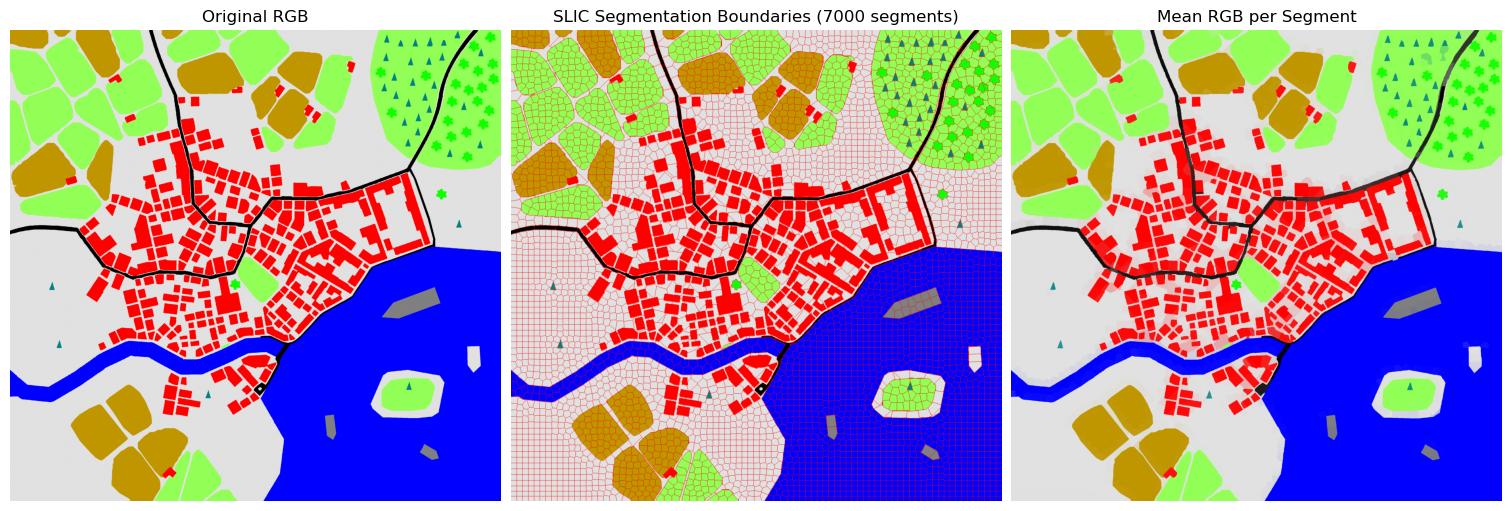

In [4]:
# File path to the image
img_path = "Artifical_landscape_UTM_012025.tif"

# Read the image and extract the bands
with rasterio.open(img_path) as src:
    # Extract red, green, blue, normalize to [0, 1]
    bands = src.read([1, 2, 3]).astype(float) / 255
    red, green, blue = bands

# Stack RGB into an array
rgb = np.stack([red, green, blue], axis=-1)

# Stack all bands into an array
image = rgb

# Set the fixed compactness and number of superpixels
compactness = 1
n_segments = 7000

# Generate segments using SLIC
segments = slic(image, n_segments=n_segments, compactness=compactness, start_label=1,sigma=1)
num_segments = len(np.unique(segments))
print((num_segments),"number of segments")

# Create the figure with 3 subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)

# Display the original RGB image
axs[0].imshow(rgb)
axs[0].set_title("Original RGB")

# Display the RGB image with segmentation boundaries for 3000 segments
axs[1].imshow(mark_boundaries(rgb, segments, color=(1, 0, 0), mode="thick"))
axs[1].set_title(f"SLIC Segmentation Boundaries ({n_segments} segments)")

# Display the mean RGB per segment
axs[2].imshow(label2rgb(segments, rgb, kind='avg'))
axs[2].set_title("Mean RGB per Segment")

# Remove axis for all subplots
for ax in axs:
    ax.set_axis_off()

# Display the combined figure
plt.show()


## **Features Extraction**

Following features were calculated for each segement to train the classifier.

* **Spectral Features** across different bands (Red, Green, Blue)
  * Intensity Mean
  * Standard Deviation

* **Shape Features**
  * Rectangularity
  * Compactness
  * Solidity

Each row in the output table below corresponds to a segment, and each column represents the associated feature values for that segment.

In [5]:
# Stack all bands into an array
full_stack_arr = np.stack([red, green, blue], axis=-1)

# Define custom features
def std(regionmask, intensity_img):
    vals = intensity_img[regionmask]
    std = np.std(vals)
    return std

def rectangularity(regionmask):
    return regionmask.sum()/regionmask.size

def compactness(regionmask):
    return 4*np.pi*regionmask.sum()/(perimeter(regionmask)**2 + 1e-6)  # small value added to avoid division by zero

# Calculate set of various features for each segment
def calc_all_feats(seg_arr, img_arr):
    spectral_feats = pd.DataFrame(
        regionprops_table(
            label_image = seg_arr,
            intensity_image = img_arr,
            properties = ["label", "intensity_mean"],
            extra_properties=(std,)
        )
    )
    shape_feats = pd.DataFrame(
        regionprops_table(
            label_image = seg_arr,
            properties = ["solidity"],
            extra_properties=(rectangularity, compactness)  #rectangularity
        )
    )

    all_feats = pd.concat([spectral_feats, shape_feats], axis=1)

    return all_feats

all_feats_df = calc_all_feats(segments, full_stack_arr)
all_feats_df = all_feats_df.rename(columns={'label': 'indx'})
display(all_feats_df)

indx  intensity_mean-0  intensity_mean-1  intensity_mean-2  \
0        1          0.752941          0.588235               0.0   
1        2          0.752941          0.588235               0.0   
2        3          0.752941          0.588235               0.0   
3        4          0.752941          0.588235               0.0   
4        5          0.752941          0.588235               0.0   
...    ...               ...               ...               ...   
4760  4761          0.000000          0.000000               1.0   
4761  4762          0.000000          0.000000               1.0   
4762  4763          0.000000          0.000000               1.0   
4763  4764          0.000000          0.000000               1.0   
4764  4765          0.000000          0.000000               1.0   

             std-0         std-1  std-2  solidity  rectangularity  compactness  
0     0.000000e+00  1.110223e-16    0.0  0.981772        0.885990     0.781121  
1     1.110223e-16  1.110223e-16    0.0  0.975840        0.819224     0.815030  
2     2.220446e-16  2.220446e-16    0.0  0.977728        0.871032     0.817603  
3     0.000000e+00  1.110223e-16    0.0  0.978723        0.929009     0.805392  
4     1.110223e-16  1.110223e-16    0.0  0.974074        0.902746     0.781287  
...            ...           ...    ...       ...             ...          ...  
4760  0.000000e+00  0.000000e+00    0.0  1.000000        1.000000     0.828350  
4761  0.000000e+00  0.000000e+00    0.0  1.000000        1.000000     0.828350  
4762  0.000000e+00  0.000000e+00    0.0  1.000000        1.000000     0.828350  
4763  0.000000e+00  0.000000e+00    0.0  1.000000        1.000000     0.828350  
4764  0.000000e+00  0.000000e+00    0.0  1.000000        1.000000     0.825365  

[4765 rows x 10 columns]

## **Image Classification using Machine Learning**

Using the **9 features** calculated above, classifier was created to identify **eight different classes** in the image. 

For better class separation and to handle more complex patterns in the data, machine learning classification methods can be more effective. These methods automatically learn the relationships between features.

For example, Random Forest is a popular algorithm that works by creating multiple decision trees during training. Each tree makes a prediction, and the Random Forest aggregates these predictions to determine the final output. This method helps improve accuracy and reduces the risk of overfitting.

The key stages of this classification approach are:

<img src="https://github.com/mariarodriguezn/obia_tutorials/blob/main/assets/image_classification_workflow.png?raw=true" width="800">






### Sample data collection widget

The following script allows you to get the index (idx) of the segments by clicking. The **on_click** function is triggered when the image is clicked and updates the title with the index of the selected segment.

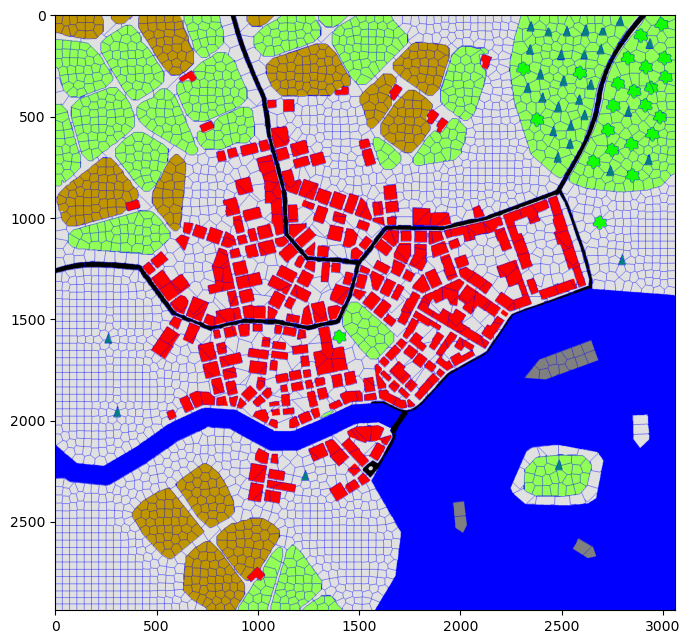

In [6]:
#uncomment this line to enable click in image
# %matplotlib widget  

# Display the RGB image with segmentation boundaries
fig, ax = plt.subplots(ncols=1,figsize=(8, 8))
ax.imshow(mark_boundaries(rgb, segments, color=(0, 0, 1), mode="thicker"))

# Function to handle the onclick event
def on_click(event):
    if event.inaxes == ax:
        # Get the mouse position in the image (clicked position)
        x, y = int(event.xdata), int(event.ydata)

        # Check if the position is valid (within image bounds)
        if 0 <= x < segments.shape[1] and 0 <= y < segments.shape[0]:
            segment_label = segments[y, x]  # Get the segment label
            ax.set_title(f"Segment Label: {segment_label}")  # Update the title
            plt.draw()  # Redraw the figure to reflect the change

# Set up the onclick event handler
fig.canvas.mpl_connect('button_press_event', on_click)

# Show the plot
plt.show()

#### **Label Image Segments**

The idxs of samples collected above are defined here as follows:

-1 : Unlabelled segments

1: cropland

2: meadow

3: road

4: water

5: buildings

6: non_vegetated

7: deciduous trees

8: coniferous trees

In [7]:
# Samples for all eight different classes
cropland_idxs=[11,396,489,1400,3818,1532,1470,810,594,1224,1388,13] #class=1
meadow_idxs=[376,1040,44,2229,1099,514,65,3533,983,807] #class=2
road_idxs=[1814,722,3303,552,2870] #class=3
water_idxs=[3219,2005,3059,2483,4360,3108,2982,3090] #class=4
buildings_idxs=[1937,1954,1730,2622,1912,1478,2026,1803,1864,1836] #class=5
non_vegetated_space=[1122,1306,1872,1599,2297,1492,4027,3123,2343,2589,1235,1775,461,178,1785,2511,3250,3045,4543,1082,3812] #class=6 
deciduous_idxs=[516,1524,390,404,70] #class=7 
coniferous_idxs=[2874,558,1159,723,1773,136,235] #class=8


# Initialize the 'class' column in all_feats_df to -1 (for unlabeled segments)
all_feats_df['class'] = -1

# Update the 'class' column for tree segments (label 1)
all_feats_df.loc[all_feats_df['indx'].isin(cropland_idxs), 'class'] = 1
all_feats_df.loc[all_feats_df['indx'].isin(meadow_idxs), 'class'] = 2
all_feats_df.loc[all_feats_df['indx'].isin(road_idxs), 'class'] = 3
all_feats_df.loc[all_feats_df['indx'].isin(water_idxs), 'class'] = 4
all_feats_df.loc[all_feats_df['indx'].isin(buildings_idxs), 'class'] = 5
all_feats_df.loc[all_feats_df['indx'].isin(non_vegetated_space), 'class'] = 6
all_feats_df.loc[all_feats_df['indx'].isin(deciduous_idxs), 'class'] = 7
all_feats_df.loc[all_feats_df['indx'].isin(coniferous_idxs), 'class'] = 8

# Display the DataFrame
display(all_feats_df)


indx  intensity_mean-0  intensity_mean-1  intensity_mean-2  \
0        1          0.752941          0.588235               0.0   
1        2          0.752941          0.588235               0.0   
2        3          0.752941          0.588235               0.0   
3        4          0.752941          0.588235               0.0   
4        5          0.752941          0.588235               0.0   
...    ...               ...               ...               ...   
4760  4761          0.000000          0.000000               1.0   
4761  4762          0.000000          0.000000               1.0   
4762  4763          0.000000          0.000000               1.0   
4763  4764          0.000000          0.000000               1.0   
4764  4765          0.000000          0.000000               1.0   

             std-0         std-1  std-2  solidity  rectangularity  \
0     0.000000e+00  1.110223e-16    0.0  0.981772        0.885990   
1     1.110223e-16  1.110223e-16    0.0  0.975840        0.819224   
2     2.220446e-16  2.220446e-16    0.0  0.977728        0.871032   
3     0.000000e+00  1.110223e-16    0.0  0.978723        0.929009   
4     1.110223e-16  1.110223e-16    0.0  0.974074        0.902746   
...            ...           ...    ...       ...             ...   
4760  0.000000e+00  0.000000e+00    0.0  1.000000        1.000000   
4761  0.000000e+00  0.000000e+00    0.0  1.000000        1.000000   
4762  0.000000e+00  0.000000e+00    0.0  1.000000        1.000000   
4763  0.000000e+00  0.000000e+00    0.0  1.000000        1.000000   
4764  0.000000e+00  0.000000e+00    0.0  1.000000        1.000000   

      compactness  class  
0        0.781121     -1  
1        0.815030     -1  
2        0.817603     -1  
3        0.805392     -1  
4        0.781287     -1  
...           ...    ...  
4760     0.828350     -1  
4761     0.828350     -1  
4762     0.828350     -1  
4763     0.828350     -1  
4764     0.825365     -1  

[4765 rows x 11 columns]

NOTE: all_feats_df is used for random forest based classification and all_feats_df_svc copy is created for SVC based classifiaction

In [8]:
all_feats_df_svc=all_feats_df.copy()

In [9]:
cropland_c, meadow_c, road_c, water_c, settlement_c, non_vegetated_c,deciduous_c,coniferous_c = '#ed8d26','#65db44', '#91431f','#0000FF','#FF0000','#decfca','#3c9955','#116327' #,'#FFA500'
# cmap = mcolors.ListedColormap([cropland_c, meadow_c, road_c, water_c, settlement_c, non_vegetated_c,deciduous_c,coniferous_c])
# cropland_c, meadow_c, road_c, water_c, settlement_c, non_vegetated_c,deciduous_c,coniferous_c,boat_c = '#f79b59','#65db44', '#91431f','#0000FF','#FF0000','#decfca','#3c9955','#116327','#000000' #,'#FFA500'
color_map_list=[cropland_c, meadow_c, road_c, water_c, settlement_c, non_vegetated_c,deciduous_c,coniferous_c]
cmap = mcolors.ListedColormap(color_map_list)

class_labels = {
    0: "Cropland",
    1: "Meadow",
    2: "Road",
    3: "Water",
    4: "Buildings",
    5: "Non-Vegetated",
    6: "Deciduous Trees",
    7: "Coniferous Trees",
}

# Define colors from your custom colormap
class_colors = {
    0: cropland_c,  
    1: meadow_c,  
    2: road_c,   
    3: water_c,   
    4: settlement_c,  
    5: non_vegetated_c ,
    6: deciduous_c,
    7: coniferous_c,
}

# Create legend patches
legend_patches = [mpatches.Patch(color=class_colors[key], label=class_labels[key]) for key in class_labels]


### Sample data map

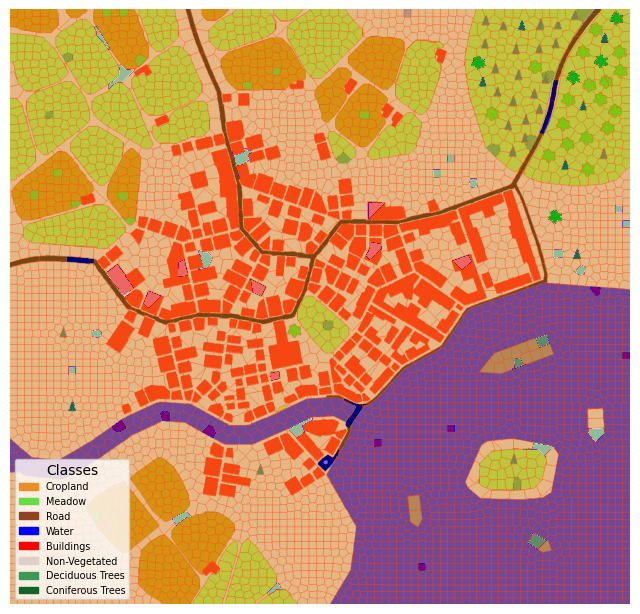

In [10]:
# Map the labeled segments onto the original segmented image
mapped_samples = map_array(
    segments,
    np.array(all_feats_df["indx"]),
    np.array(all_feats_df["class"])
)

# Display the original image with segment boundaries
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(rgb, segments, (1, 0, 0), mode="outer"))

# Overlay the labeled segments with the defined colors
plt.imshow(mapped_samples, cmap=cmap, alpha=0.5)
plt.legend(handles=legend_patches, loc="lower left", fontsize="x-small", title="Classes")

# Turn off the axis for a cleaner look
plt.axis("off")

# Show the plot
plt.show()

As evidenced in the image above, the samples adhere to several key principles when selecting or creating training data for a classification model

*  **Homogeneity**: Segments are chosen to be internally consistent, representing a single class to minimize noise in the training data.
*   **Representativeness**: The samples capture the full range of variability within each class, including different textures, colors, and shapes.
*   **Spatial Distribution**: The samples are distributed across the image to cover different areas, preventing the model from overfitting to specific regions.

*   **Class Balance**: There is an effort to maintain a balance between different classes to prevent bias in the model and improve overall accuracy.






#### **Train Random Forest Classifier**


In this step, Random Forest model is trained.  **n_estimators** set to create 100 decision trees and use the Out-of-Bag (OOB) score to check how well the model might work on new, unseen data. The OOB score is a built-in way to test the model's accuracy without needing a separate test set, making it a practical way to assess how well the model is likely to perform.

In [11]:
# Filter out the labeled samples
labeled_segments_df = all_feats_df[all_feats_df['class'] != -1]

# Separate features (X) and class label (y)
X = labeled_segments_df.drop(columns=['indx', 'class'])
y = labeled_segments_df['class']

# Train the Random Forest Classifier using the entire dataset
clf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
clf.fit(X, y)

# Evaluate the model using OOB score
print("OOB Score:", clf.oob_score_)

OOB Score: 0.9615384615384616


The OBB score obtained using Random forest classifier in this example is 0.96202 which means model can correctly classifies 96.202% of the segments.

#### **Test the Classifier**

Now, to further evaluate the classifier, we apply the trained classifier to the **unlabeled** segments. This step is fundamental to determine how well the classifier can generalize beyond the labeled training data and make accurate predictions on new, unseen segments.

In [12]:
# Filter out the unlabeled segments
unlabeled_segments_df = all_feats_df[all_feats_df['class'] == -1]

# Separate features (X) for the unlabeled segments
X = unlabeled_segments_df.drop(columns=['indx', 'class'])

# Predict the class labels for the unlabeled segments
predictions = clf.predict(X)

# Update the original dataframe with the predictions
all_feats_df.loc[all_feats_df['class'] == -1, 'class'] = predictions

#### **Interpret the results**

Finally, to actually analyze the resulting prediction on the unlabeled segments, below the results are plot.

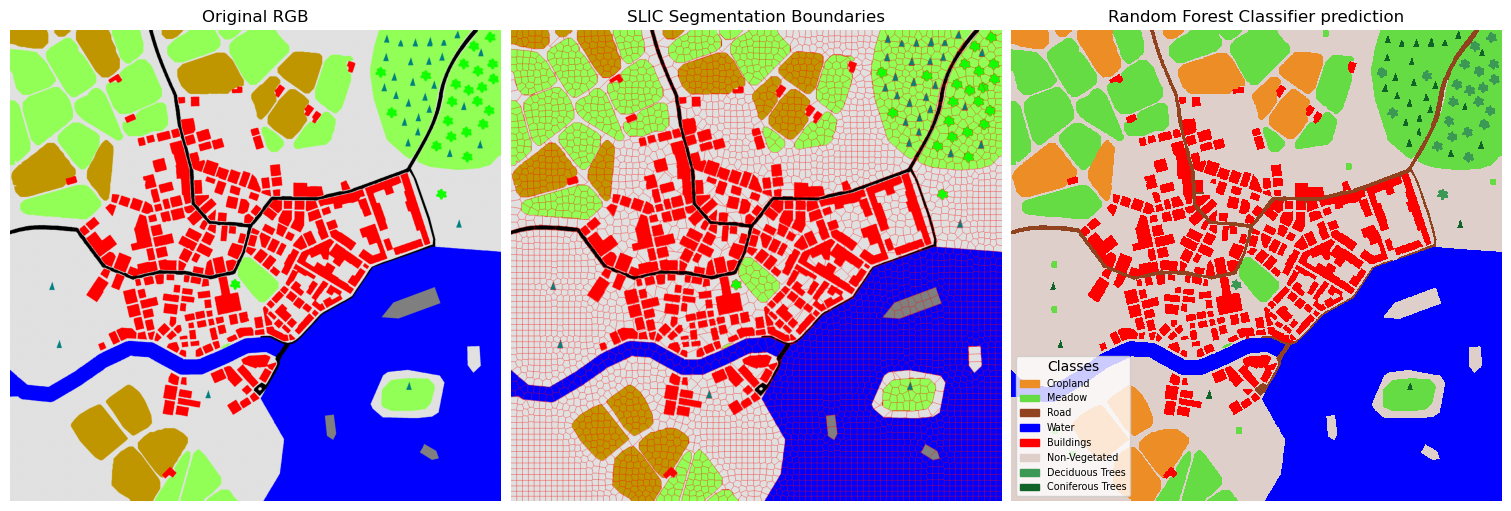

In [13]:
#  Map the predictions onto the original segmented image
mapped_rf_classification= map_array(
    segments,
    np.array(all_feats_df["indx"]),
    np.array(all_feats_df["class"]))


plot_classification_results(rgb, segments, mapped_rf_classification, cmap, legend_patches, title="Random Forest Classifier prediction")

The third figure displays the classification map generated using nine features, a limited sample dataset, and a random forest classifier. It comprises eight classes, as indicated in the legend. The results are satisfactory, with most segments correctly classified. However, some coniferous trees have been misclassified as meadows, and certain non-vegetated segments have also been incorrectly labeled as meadows.

## Classification using Support Vector Classifier

Support Vector Classifier (SVC) is a type of Support Vector Machine (SVM) used for supervised classification tasks.  (Source: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#)

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

#### Train SVC classifier

The SVC classifier is defined with the following parameters to enhance its performance for multi-class classification. 

The gamma='scale' setting automatically adjusts the kernel coefficient based on the variance of the input features, making it more adaptive to different datasets. 

The decision_function_shape='ovo' (one-vs-one) strategy is used for handling multi-class problems, where a separate SVM classifier is trained for each pair of classes, and the final prediction is based on a majority vote. 

Additionally, random_state=42 ensures that the results remain consistent across different runs by controlling the randomness in the training process. These settings help improve the classifier's ability to generalize while maintaining reproducibility.

Since the Obb_score functionality is not available for SVC. The collected sample data is splitted into the train (75%) and test(25%) datasets. 

Finally, using the score function, accuracy of the model is evaluated. (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.score)

In [15]:
# Filter out the labeled samples
labeled_segments_df_svc = all_feats_df_svc[all_feats_df_svc['class'] != -1]

# Separate features (X) and class label (y)
X = labeled_segments_df_svc.drop(columns=['indx', 'class'])
y = labeled_segments_df_svc['class']

# Split dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Model initialization
svc_clf = SVC(gamma='scale',decision_function_shape='ovo', random_state=42) 

# Training the model
svc_clf.fit(X_train, y_train)

# Evaluating the model
svc_clf.score(X_test, y_test, sample_weight=None)

0.95

The obtained accuracy for SVC is 0.95 which means model can correctly classify 95% of the segments.

### Prediction using SVC model

Prediction is carried out for the entire image segments as follow

In [16]:
# Filter out the unlabeled segments
unlabeled_segments_df_svc = all_feats_df_svc[all_feats_df_svc['class'] == -1]

# Separate features (X) for the unlabeled segments
X = unlabeled_segments_df_svc.drop(columns=['indx', 'class'])

# Predict the class labels for the unlabeled segments
predictions = svc_clf.predict(X)

# Update the original dataframe with the predictions
all_feats_df_svc.loc[all_feats_df_svc['class'] == -1, 'class'] = predictions

### Plot and interpret the SVC model result

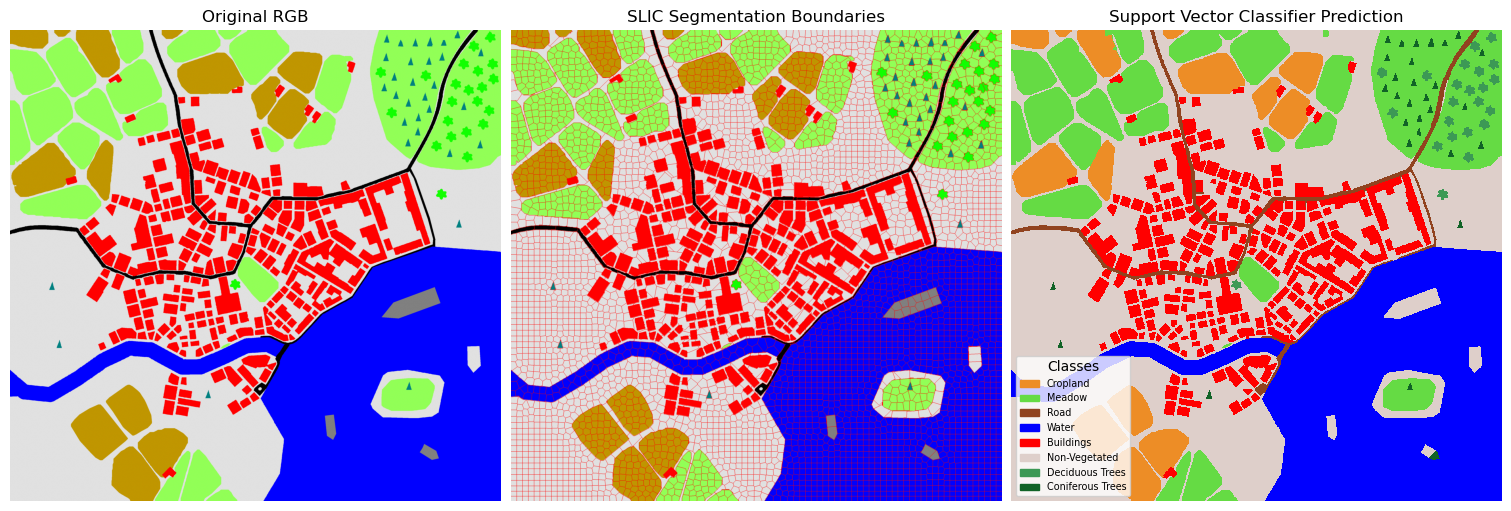

In [17]:
#  Map the predictions onto the original segmented image
mapped_svc_classification= map_array(
    segments,
    np.array(all_feats_df_svc["indx"]),
    np.array(all_feats_df_svc["class"]))

plot_classification_results(rgb, segments, mapped_svc_classification, cmap, legend_patches, title= "Support Vector Classifier Prediction")


The third image is the classification result of SVC based classifier.  It  consists of 8 classes as shown in legend.In the top-right region, some coniferous trees have been misclassified as meadows. In addition to this, one of the non-vegetated(boat head) is also missclassified as coniferous trees. 

#### Function to merge segments for specific class only

In [18]:
def find_neighbors(segment_id, segments):
    """Finds neighboring segment labels for a given segment."""
    # Get segment mask
    segment_pixels = np.argwhere(segments == segment_id)
    
    neighbor_offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    neighbors = set()

    # Loop over each pixel in the segment
    for i, j in segment_pixels:
        for di, dj in neighbor_offsets:
            ni, nj = i + di, j + dj
            if 0 <= ni < segments.shape[0] and 0 <= nj < segments.shape[1]:  # Bounds check
                neighbor_id = segments[ni, nj]
                # Check If the neighbor belongs to a different segment
                if neighbor_id != segment_id:
                    neighbors.add(neighbor_id)
    
    return list(neighbors)

def merge_by_class(segments, feat_df, class_value):
    """Merges neighboring segments of the same class."""
    
    class_map = dict(zip(feat_df['indx'], feat_df['class']))

    rows_to_drop = []
    for segment_index, segment_class in class_map.items():
        if segment_class == class_value:
            neighbor_index_list = find_neighbors(segment_index, segments)

            for n_index in neighbor_index_list:
                if class_map.get(n_index) == class_value: 
                    segments[segments == n_index] = segment_index
                    rows_to_drop.append(n_index)

    # Remove merged segments indx from feat_df
    feat_df = feat_df[~feat_df['indx'].isin(rows_to_drop)]
    
    return segments, feat_df

#### Function to get the list of segments of class_a completely surrounded by class_b segments

In [19]:
# First get the neighbouring segments indexs of class_a, and if all the class label is equals to class b, it is selected as the segments surrounded by class_b
def compute_surrounded_by(segments,feat_df,class_a,class_b):
    surrounded_segments=[]
    class_map = dict(zip(feat_df['indx'], feat_df['class']))
    for segment_index, segment_class in class_map.items():
        if segment_class == class_a:
            neighbor_index_list = find_neighbors(segment_index, segments)
            if all(class_map.get(n_index) == class_b for n_index in neighbor_index_list):
                surrounded_segments.append(segment_index)
    return surrounded_segments

#### Function to get the list of segments of class_a touched by class_b segments

In [20]:
# First get the neighbouring segments indexs of class_a, and if one of the class label is equals to class b, it is selected as the segments touched by class_b
def compute_touched_by(segments,feat_df,class_a,class_b):
    touched_segments=[]
    class_map = dict(zip(feat_df['indx'], feat_df['class']))
    for segment_index, segment_class in class_map.items():
        if segment_class == class_a:
            neighbor_index_list = find_neighbors(segment_index, segments)
            if any(class_map.get(n_index) == class_b for n_index in neighbor_index_list):
                touched_segments.append(segment_index)
    return touched_segments

### Merging non-vegetation and water class segments

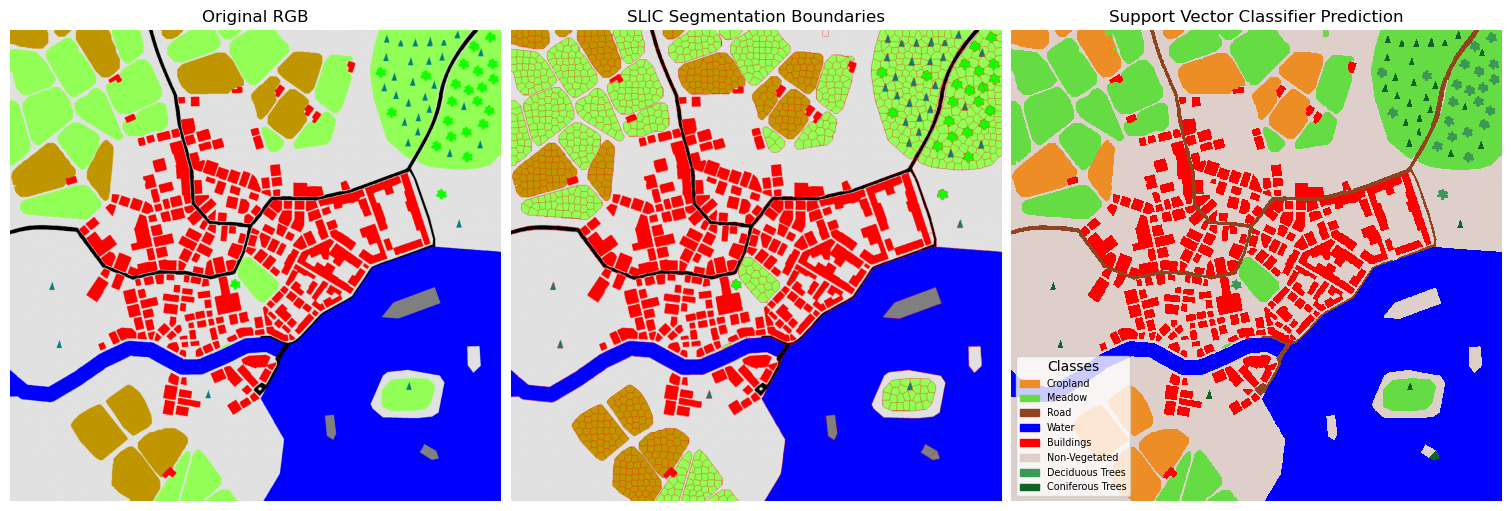

In [21]:
segments_c=segments.copy() 
all_feats_df_svc_c=all_feats_df_svc.copy()

# Call function to merge the non_vegetation (6) class segments
merged_segments_svc, merged_all_feats_df_svc = merge_by_class(segments_c,all_feats_df_svc_c,6)
# Call function to merge the water (6) class segments
merged_segments_svc, merged_all_feats_df_svc = merge_by_class(merged_segments_svc,merged_all_feats_df_svc,4)

# plot updated merged segments
mapped_merged_svc_classification= map_array(
    merged_segments_svc,
    np.array(merged_all_feats_df_svc["indx"]),
    np.array(merged_all_feats_df_svc["class"]))

plot_classification_results(rgb, merged_segments_svc, mapped_merged_svc_classification, cmap, legend_patches, title= "Support Vector Classifier Prediction")

Second figure is the result of updated segments where non_vegetation class segments are merged.

### Adding boat class

In [22]:
#updatings cmap and legend
boat_c = '#ECD817'

updated_class_labels=class_labels
updated_class_labels[8]="Boat"
updated_class_colors=class_colors
updated_class_colors[8]=boat_c

color_map_list=list(updated_class_colors.values())
updated_cmap = mcolors.ListedColormap(color_map_list)

# Create legend patches
updated_legend_patches = [mpatches.Patch(color=updated_class_colors[key], label=updated_class_labels[key]) for key in updated_class_labels]


boat_segments_ids:  [2543, 3123, 3675]
[1 2 3 4 5 6 7 8]
[1 2 3 4 5 6 7 8 9]


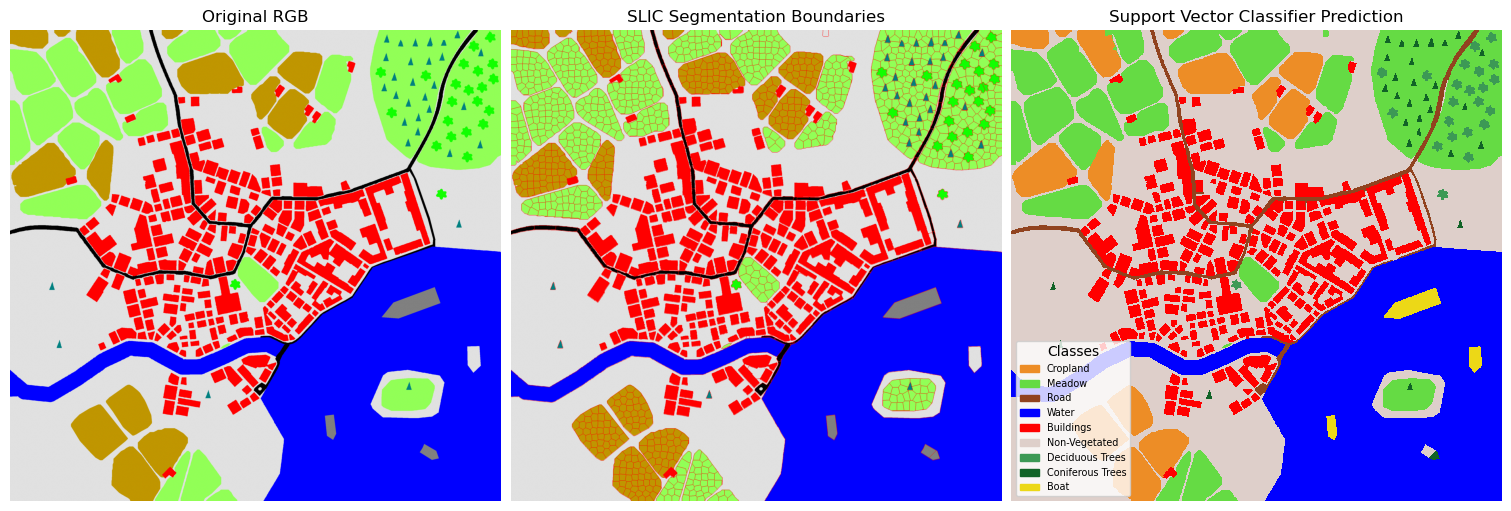

In [23]:
BOAT_CLASS=9 #class id for boat class

NON_VEG_CLASS=6 # based on classification
WATER_CLASS=4 # based on classification

# call the  function to get the list of non_vegetation class(6) surrounded by water(4) for SVC based classification
boat_segments_ids=compute_surrounded_by(merged_segments_svc, merged_all_feats_df_svc, NON_VEG_CLASS, WATER_CLASS)
print("boat_segments_ids: ",boat_segments_ids)

# Print the unique values in the class column before adding boat class
print(np.unique(merged_all_feats_df_svc["class"]))

# Update the class column in all_feats_df based on the indices from boats_segments
merged_all_feats_df_svc["class"] = np.where(merged_all_feats_df_svc["indx"].isin(boat_segments_ids), BOAT_CLASS, merged_all_feats_df_svc["class"])

# Print the unique values in the class column after the update
print(np.unique(merged_all_feats_df_svc["class"]))

# updated_segments, updated_class_indices, updated_class_labels
mapped_merged_rf_classification= map_array(
    merged_segments_svc,
    np.array(merged_all_feats_df_svc["indx"]),
    np.array(merged_all_feats_df_svc["class"]))

plot_classification_results(rgb, merged_segments_svc, mapped_merged_rf_classification, updated_cmap, updated_legend_patches, title= "Support Vector Classifier Prediction")

Third figure is the updated SVC based classification map with added class "Boat" represented by yellow color. Out of four, one boat is not classified because part of its segment is classified as coniferous tree.

### Adding farmhouse class


In [24]:
# updating cmap and legend
farmhouse_c = '#723a7a'

updated_class_labels[9]="Farmhouse"
updated_class_colors[9]=farmhouse_c

color_map_list=list(updated_class_colors.values())
updated_cmap = mcolors.ListedColormap(color_map_list)

# Create legend patches
updated_legend_patches = [mpatches.Patch(color=updated_class_colors[key], label=updated_class_labels[key]) for key in updated_class_labels]


farmhouse_segment_ids:  [567, 580, 751, 1422, 4322, 352, 464, 818, 829, 4322]
[1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


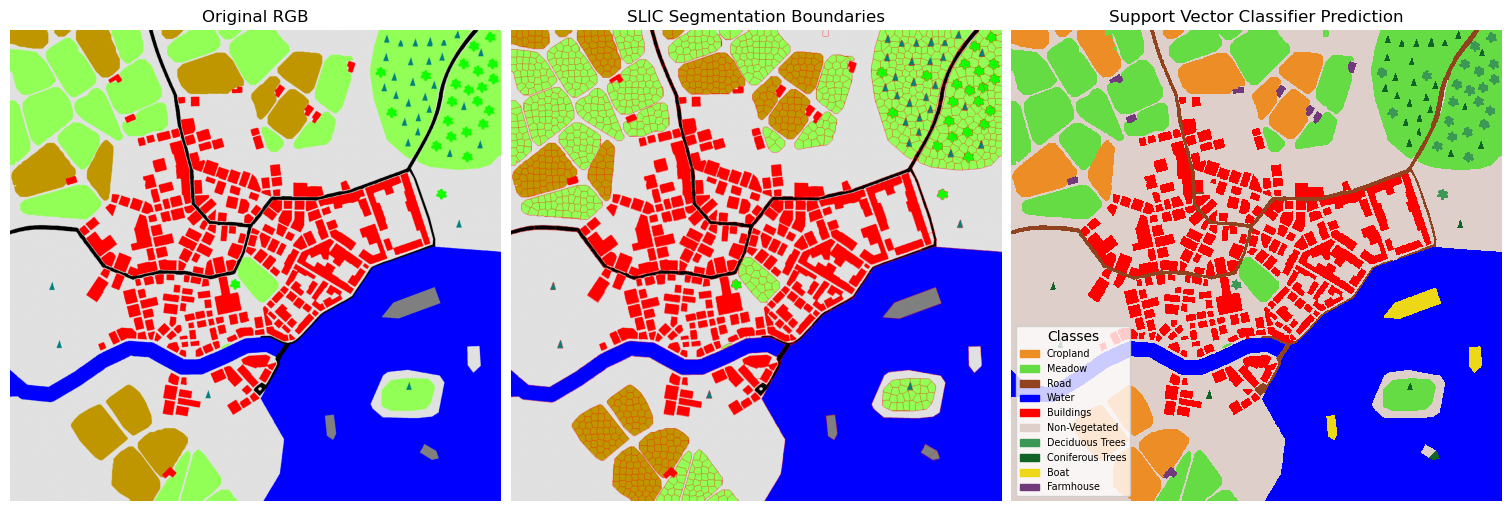

In [25]:
FARMHOUSE_CLASS=10  #new class_idx for farmhouse

# call the  function to get the list of buildings(5) touched by meadow(1) or cropland(2) for SVC based classification
farmhouse_meadow_ids=compute_touched_by(merged_segments_svc, merged_all_feats_df_svc, 5, 1)
farmhouse_cropland_ids=compute_touched_by(merged_segments_svc, merged_all_feats_df_svc, 5, 2)

farmhouse_ids= farmhouse_meadow_ids + farmhouse_cropland_ids
print("farmhouse_segment_ids: ",farmhouse_ids)

# Print the unique values in the class column after the update
print(np.unique(merged_all_feats_df_svc["class"]))

# Update the class column in all_feats_df based on the indices from farmhouse_ids
merged_all_feats_df_svc["class"] = np.where(merged_all_feats_df_svc["indx"].isin(farmhouse_ids), FARMHOUSE_CLASS, merged_all_feats_df_svc["class"])

# Print the unique values in the class column after the update
print(np.unique(merged_all_feats_df_svc["class"]))

# updated_segments, updated_class_indices, updated_class_labels
mapped_merged_rf_classification= map_array(
    merged_segments_svc,
    np.array(merged_all_feats_df_svc["indx"]),
    np.array(merged_all_feats_df_svc["class"]))

plot_classification_results(rgb, merged_segments_svc, mapped_merged_rf_classification, updated_cmap, updated_legend_patches, title= "Support Vector Classifier Prediction")

Farmhouse is added and is represented by purple color as shown in third image above

### Classifying river and lake

Identifying the river or lake class based on solidity property


In [26]:
# updating class color
lake_c = '#53b5ed'
river_c= '#1f6e9c'
updated_class_labels[10]="River"
updated_class_colors[10]=river_c
updated_class_labels[11]="Lake"
updated_class_colors[11]=lake_c

color_map_list=list(updated_class_colors.values())
updated_cmap = mcolors.ListedColormap(color_map_list)

# Create legend patches
updated_legend_patches = [mpatches.Patch(color=updated_class_colors[key], label=updated_class_labels[key]) for key in updated_class_labels]


[ 1  2  3  5  6  7  8  9 10 11 12]


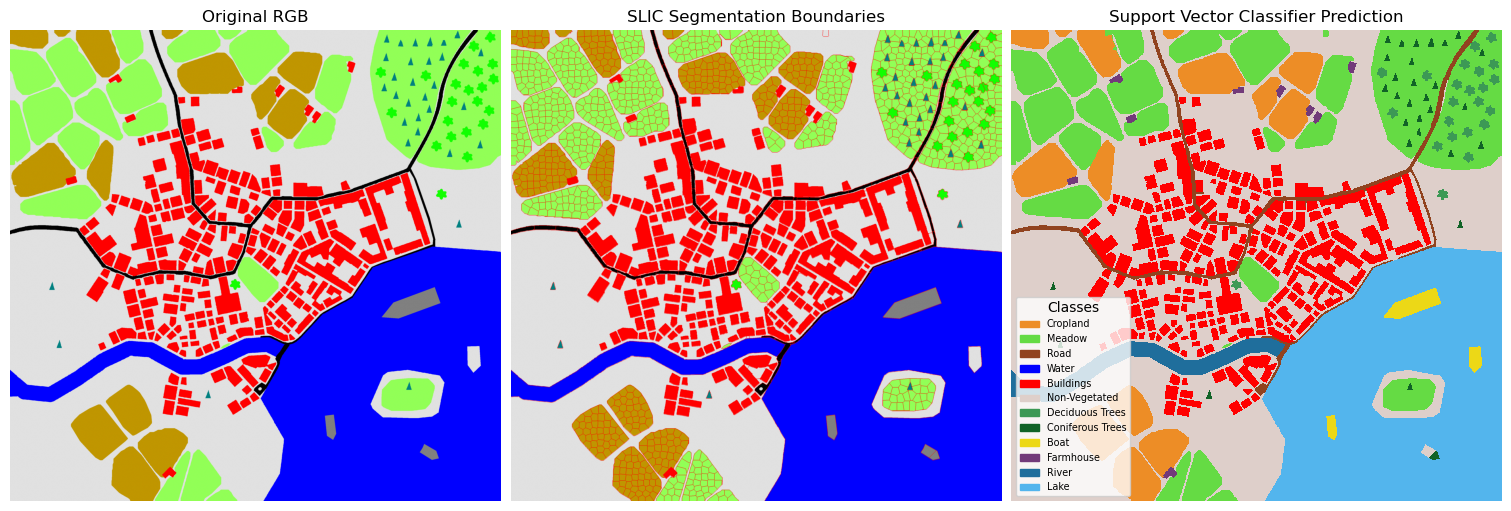

In [27]:
RIVER_CLASS=11
LAKE_CLASS=12
# updating class column in all_feats_df by assigning class as river if its class is equal to water(4) and solidity is less than 1,  likewise as lake if its class is equal to water(4) and solidity is greater_than_or_equal_to 1
merged_all_feats_df_svc["class"] = np.where((merged_all_feats_df_svc["class"]==4) & (merged_all_feats_df_svc["solidity"]<1), RIVER_CLASS, merged_all_feats_df_svc["class"])
merged_all_feats_df_svc["class"] = np.where((merged_all_feats_df_svc["class"]==4) & (merged_all_feats_df_svc["solidity"]>=1), LAKE_CLASS, merged_all_feats_df_svc["class"])

# Print the unique values in the class column after the update
print(np.unique(merged_all_feats_df_svc["class"]))

# updated_segments, updated_class_indices, updated_class_labels
mapped_merged_rf_classification= map_array(
    merged_segments_svc,
    np.array(merged_all_feats_df_svc["indx"]),
    np.array(merged_all_feats_df_svc["class"]))

plot_classification_results(rgb, merged_segments_svc, mapped_merged_rf_classification, updated_cmap, updated_legend_patches, title= "Support Vector Classifier Prediction")

## **Conclusion**

In this extended classification notebook, the analysis was enhanced by incorporating a new image, Artificial_landscape_UTM_012025, and refining segmentation using the SLIC method. The classification was expanded from binary to multiple land cover classes, including cropland, meadow, road, water, buildings, non-vegetated, deciduous and coniferous trees and boat. A script was integrated to facilitate sample collection by allowing users to interactively select segment indices from an RGB image with segmentation boundaries. 

Supervised classification was performed using the existing Random Forest model, and then by SVC-based classification. In this case, Random Forest model (accuracy= 96%) outperforms in comparision to  SVC based classification (accuracy= 95%). 
However, the difference is minimal, and both models demonstrate comparable performance.

The boat, farmhouse, lake and river classes were introduced later.

Finally, a legend was added to improve the interpretability of the classification map.

Regarding computation time, initial segemntation step was time consuming than the traning and prediction process.